# To do:
- epochs minimo 200
- ponerle una tol a las loss funciont
- no probar sobre TOOODAS las combinaciones de hiperparametros (beta de adam 2 valores, epochs mas o menos fijo)
- hacer visualizacion de funcion de costo
- ver el autovalor maximo vs epochs


mucha energia en los k bajo, poca energia en los k alto.

transformada de fourier en el medio de la imagen en el eje y, a lo largo del eje x. 

# Preguntas Pato:
- Al momento de hacer histogramas activaciones, tenemos que usar los mismos inputs para evaluar como van cambiando los histpgramas a medida que avanza el entrenamiento.
- el hessiano esta bien calcularlo en 1 un batch?
- como visualizamos el espectro del hessiano? tipo de analisis?
-  curva de numero de condicion vs epocjs
- cuando no estas en un punto critico, que significa tener autoval positivo y negativo? saddle point ?
- mostrar histogramas de hessiano

In [2]:
import nn_functions

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import nn

import numpy as np

import matplotlib.pyplot as plt

from itertools import product

from nn_functions import init_network_params, pack_params, layer_sizes, unpack_params
from nn_functions import update_rmsprop, update_sgd, compute_hessian, update_adam
from nn_functions import get_batches, loss, batched_predict, batched_predict_with_activations

Evaluar la performance de cada optimizador estudiando el valor de la función de costo, la calidad del
ajuste, número de iteraciones necesarias para converger (si es posible). Puede incluir también histogramas de las activaciones de las redes y de los gradientes, y calcular el espectro del Hessiano a lo largo
del entrenamiento.

In [3]:
# Load data
field = jnp.load('field.npy')
field = field - field.mean()
field = field / field.std()
field = jnp.array(field, dtype=jnp.float32)
nx, ny = field.shape
xx = jnp.linspace(-1, 1, nx)
yy = jnp.linspace(-1, 1, ny)
xx, yy = jnp.meshgrid(xx, yy, indexing='ij')
xx = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
ff = field.reshape(-1, 1)

# SGD con minibatch

In [38]:
def const_scheduler(step_size, epoch, step_size_0=0.001, r=100):
    return step_size

In [39]:
def exp_scheduler(step_size, epoch, step_size_0=0.001, r=100):
    return step_size_0 * 10**(-epoch / r)
	

In [40]:
def entrenar_red(configuracion):
	
	num_epochs = configuracion['num_epochs']
	batch_size = configuracion['batch_size']
	cant_epochs_a_registrar = configuracion['cant_epochs_a_registrar']
	tol_loss = configuracion['tol_loss']
	epochs_a_registrar = configuracion['epochs_a_registrar']
	update = configuracion['update']
	step_size_0 = configuracion['step_size_0']
	r = configuracion['r']
	scheduler = configuracion['scheduler']
	
	#Early stopping
	best_loss = float('inf')
	patience = 10
	wait = 0   

	#Parámetros de la red
	params = init_network_params(layer_sizes, random.key(0))
	params = pack_params(params)

	# Logs
	log_train = []
	log_grads = []
	log_activations = []
	log_hessian = [] 

	#Entrenamiento
	#Iterable para obtener batches
	xi, yi = next(get_batches(xx, ff, bs=num_epochs))  # xi:[x,y], yi:color

	# Gradientes
	grads = grad(loss)(params, xi, yi)
	aux = jnp.square(grads) # Necesario para el optimizador.

	step_size = step_size_0

	for epoch in range(num_epochs):
		# Generar los batches y realizar el entrenamiento del epoch.
		step_size = scheduler(step_size, epoch, step_size_0, r)

		idxs = random.permutation(random.key(0), xx.shape[0])
		for xi, yi in get_batches(xx[idxs], ff[idxs], bs=batch_size):
			params, aux, grads = update(params, xi, yi, step_size, aux)
		
		#Registrar el loss al finalizar cada epoch.
		train_loss = loss(params, xx, ff)
		log_train.append(train_loss.item()) # funcion de costo
		
		# Early stopping check
		if train_loss < best_loss - tol_loss:   
			best_loss = train_loss          
			wait = 0                        
		else:                               
			wait += 1                       
			if wait >= patience:           
				print(f"Corte temprano por paciencia en epoch {epoch}")  
				break    
		
		#Registrar los gradientes, activaciones y hessiano cada 20 epochs.
		if epoch in epochs_a_registrar:
			log_grads.append(grads) # un array de shape 4000 aprox
			# Obtener activaciones sobre todo el dataset
			outputs, activations = batched_predict_with_activations(params, xx) # para toda la imagen xx= (77184, 2)
			# outputs, activations = batched_predict_with_activations(params, xi)
			# activations es una lista de arrays, uno por capa, de shape (N, neurons_in_layer)
			log_activations.append(activations)
			log_hessian.append(compute_hessian(params, xi, yi))
			
			print(f"Epoch {epoch}, Loss: {train_loss}")

	print(f"Epoch {epoch}, Loss: {train_loss}")
 
	resultados = {
		'log_train' : log_train,
		'log_grads': log_grads,
		'log_activations' : log_activations,
		'log_hessian' : log_hessian,
		'params' : params
	}	
	
	return resultados

In [42]:
# Parámetros
num_epochs = 5
batch_size = 128
cant_epochs_a_registrar = 4
tol_loss = 1e-5 

epochs_a_registrar = np.linspace(0, num_epochs, cant_epochs_a_registrar, dtype=int)
epochs_a_registrar[-1] -= 1 

# Optimizador
update = update_sgd
step_size_0 = 0.001
scheduler = const_scheduler
r = num_epochs / 2 

configuracion = {
	'num_epochs': num_epochs,
	'batch_size': batch_size,
	'cant_epochs_a_registrar': cant_epochs_a_registrar,
	'tol_loss': tol_loss,
	'epochs_a_registrar': epochs_a_registrar,
	'update' : update,
	'step_size_0': step_size_0,
	'r' : r,
	'scheduler': scheduler
}

In [43]:
resultados_modelo = entrenar_red(configuracion)

Epoch 0, Loss: 0.7407254576683044


KeyboardInterrupt: 

# Train Loss

In [8]:
def plot_loss(log_train):
    plt.figure(figsize=(6, 4))

    plt.plot(log_train, label='Training Loss', linewidth=2)

    plt.title('Training Loss a lo largo de las epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    plt.grid(True)
    plt.legend(fontsize=12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

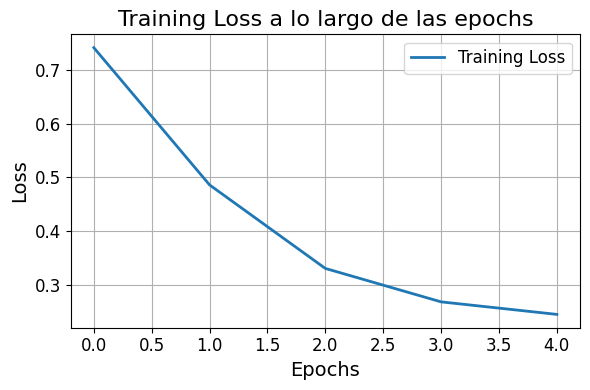

In [9]:
plot_loss(resultados_modelo['log_train'])

## Evaluar calidad del ajuste. Graficos de la imagen.

In [24]:
def plot_comparacion_imagenes(params):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    plt.suptitle("Predicción de la red neuronal", fontsize=16)

    #Original
    axes[0].imshow(ff.reshape((nx, ny)).T, origin='lower', cmap='jet')
    axes[0].set_title(f"Original")

    #Predicción
    result= batched_predict(params, xx)
    axes[1].imshow(result.reshape((nx, ny)).T, origin='lower', cmap='jet')
    axes[1].set_title(f"Predicción")

    plt.show()

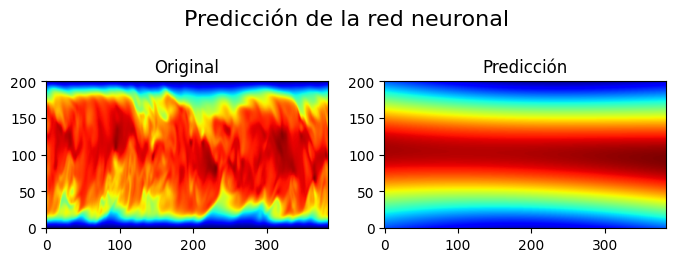

In [25]:
plot_comparacion_imagenes(resultados_modelo['params'])

<font color="orange"> TODO: Grafico de error por pixel, y MSE contando todos los puntos.

# Histograma de gradientes
- histograma de componentes del gradiente por capa. entendemos que para distintas epochs. (cada tantas epochs calcular el gradiente sobre algunos puntps). 

In [13]:
def plot_grads(log_grads):
	# Inicializamos estructuras para acumular gradientes
	num_layers = len(layer_sizes) - 1
	grad_weights_by_layer = [[] for _ in range(num_layers)]
	grad_biases_by_layer = [[] for _ in range(num_layers)]

	# Recolectamos gradientes por capa y tipo
	for grads in log_grads:
		layer_grads = unpack_params(grads)  # Lista de (w, b) por capa
		for i, (w, b) in enumerate(layer_grads):
			grad_weights_by_layer[i].append(w.flatten())
			grad_biases_by_layer[i].append(b.flatten())

	# Colores por epoch
	epochs = epochs_a_registrar
	colors = ['blue', 'orange', 'green', 'red', 'purple']  # Asegurar de tener >= len(log_grads)

	data_by_type = [grad_weights_by_layer, grad_biases_by_layer]
	type_names = ["pesos", "biases"]

	# Subplots: filas = capas, columnas = [weights, biases]
	fig, axs = plt.subplots(num_layers, 2, figsize=(12, 4 * num_layers), squeeze=False)

	for layer_idx in range(num_layers):    # filas
		for type_idx, (grad_by_layer, param_type) in enumerate(zip(data_by_type, type_names)):  # columnas
			ax = axs[layer_idx, type_idx]
			grad_list = grad_by_layer[layer_idx]
			for j, grad_values in enumerate(grad_list):
				ax.hist(
					grad_values, bins=50, alpha=0.5, density=True, 
					label=f"Epoch {epochs[j]}", color=colors[j]
				)
			ax.set_title(f"Gradientes de {param_type} - Capa {layer_idx+1}")
			ax.set_xlabel("Valor del gradiente")
			ax.set_ylabel("Densidad")
			ax.grid(True)
			ax.legend(fontsize=8)

	plt.tight_layout(rect=[0, 0, 1, 0.97])
	fig.suptitle("Histograma de Gradientes por Capa y Tipo", fontsize=18)
	plt.show()

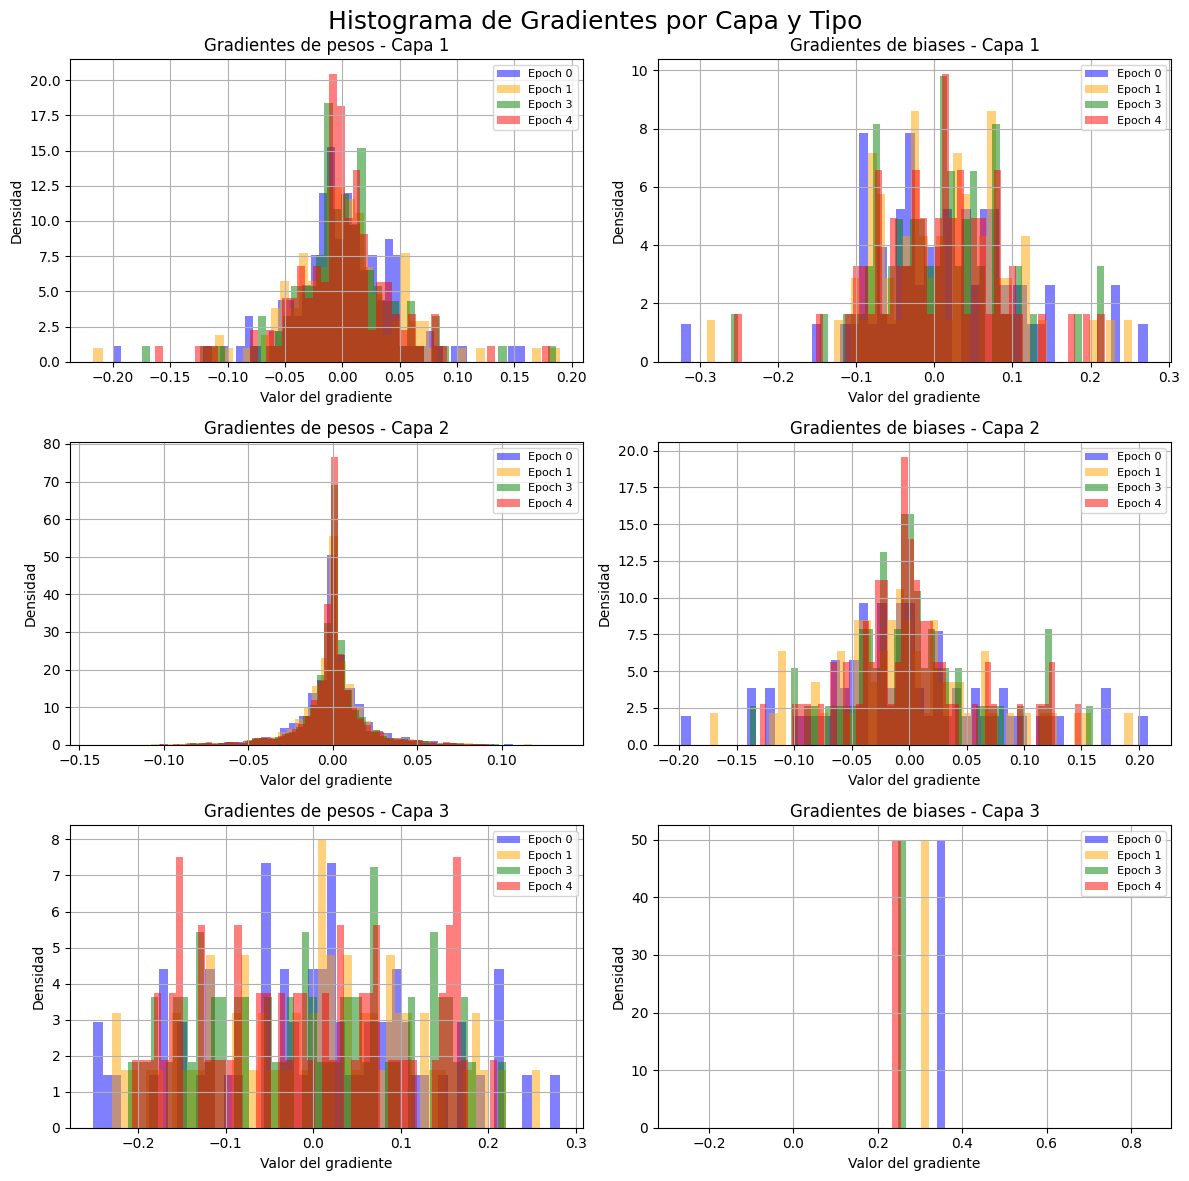

In [15]:
plot_grads(resultados_modelo['log_grads'])

<font color="orange"> TODO: solo graficar 3 epochs, graficar kde, eliminar los que son 1 solo valor 

# Histograma de activaciones 

In [16]:
def plot_activations(log_activations):
	num_epochs = len(log_activations)
	num_layers = len(log_activations[0])
	colors = plt.cm.viridis(np.linspace(0,1,num_layers))  # 1 colorificado por capa (opcional)

	fig, axs = plt.subplots(num_epochs, num_layers, figsize=(8*num_layers, 3*num_epochs), squeeze=False)

	for i_epoch, num_real_epoch in enumerate(epochs_a_registrar):      # Filas → epochs
		activs = log_activations[i_epoch]
		for i_layer in range(num_layers):  # Columnas → capas
			ax = axs[i_epoch, i_layer]
			data = np.ravel(np.array(activs[i_layer]))
			ax.hist(data, bins=50, alpha=0.7, color=colors[i_layer], density=True)
			ax.set_xlim([-1, 1])
			if i_epoch == 0:
				ax.set_title(f'Capa {i_layer+1}')
			if i_layer == 0:
				ax.set_ylabel(f'Epoch {num_real_epoch}')
			ax.set_xlabel("Valor de activación")
			ax.grid(True)

	plt.tight_layout(rect=[0, 0, 1, 0.96])
	fig.suptitle("Histogramas de activaciones\n(Filas: epochs, Columnas: capas)", fontsize=18)
	plt.show()

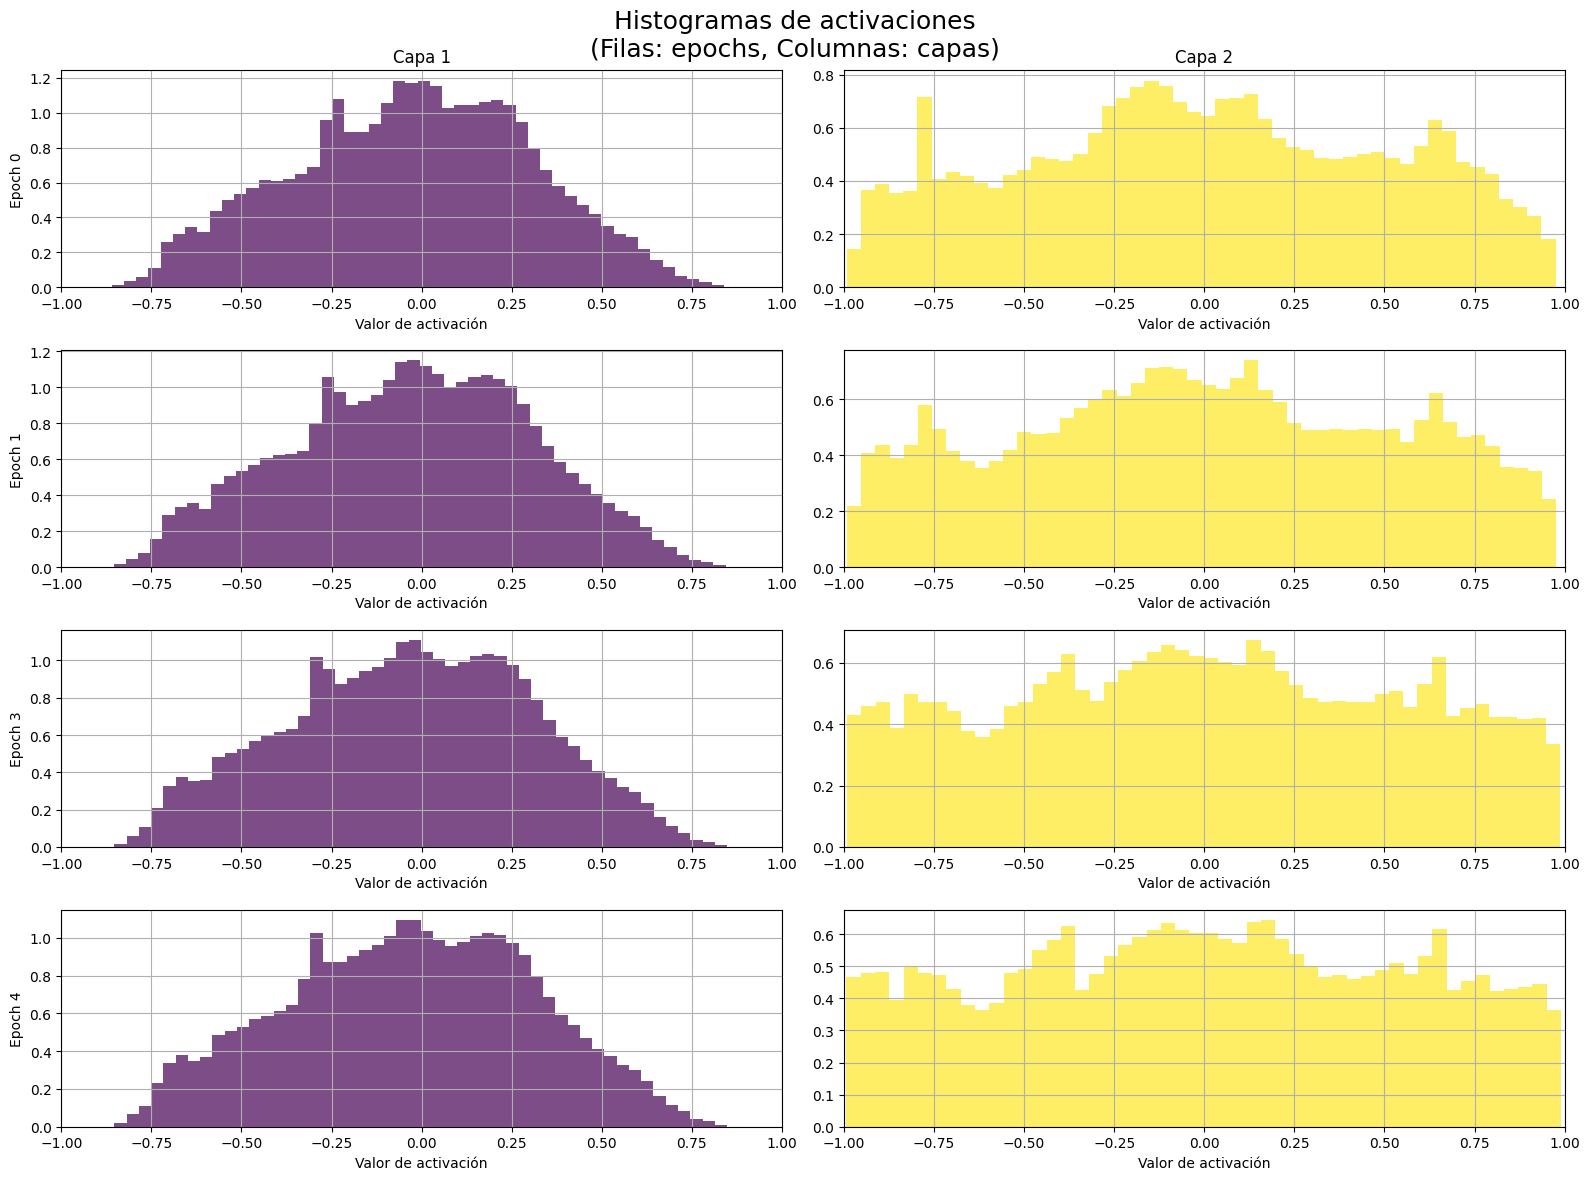

In [17]:
plot_activations(resultados_modelo['log_activations'])

In [18]:
def plot_hessian(log_hessian):
	num_logs = len(log_hessian)
	ncols = 2  # columnas por fila
	nrows = (num_logs + ncols - 1) // ncols  # filas necesarias

	fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
	axes = axes.flatten()  # aplanamos para indexar fácil

	for i, hessian in enumerate(log_hessian):
		
		#Obtenger autovalores y los mismos en valor absoluto
		eigvals, _ = jnp.linalg.eigh(hessian)
		eigvals = jnp.array(eigvals)
		abs_eigvals = jnp.abs(eigvals)
		
		# Obtener autovalor máximo y mínimo en valor absoluto. Evito autovalores MUY pequeños para evitar
		# dvisión por cero.
		lambda_max = jnp.max(abs_eigvals)
		lambda_min = jnp.clip(jnp.min(abs_eigvals), a_min=1e-10)  # evitar división por 0

		#Bins de tamaño logarítmico
		bins = jnp.logspace(jnp.log10(0.000001), jnp.log10(100), num=40)
		
		#Ploteo
		axes[i].hist(eigvals, bins=bins, color="steelblue", edgecolor="black")

		axes[i].set_title(f"Epoch {epochs_a_registrar[i]}.  Nro. condicion{lambda_max / lambda_min}.")  # o el número real si lo tenés

		axes[i].set_xlabel("Autovalores")
		axes[i].set_xscale("log")  # ← Escala log en eje Y (frecuencia)
		axes[i].set_ylabel("Frecuencia")
		

	# Apagar subplots vacíos si hay
	for j in range(i+1, len(axes)):
		axes[j].axis("off")

	plt.tight_layout()
	plt.show()

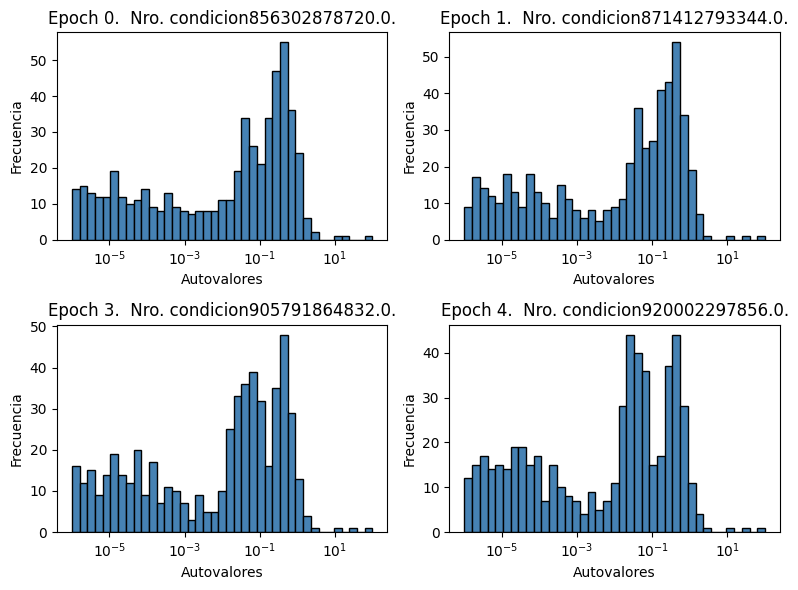

In [19]:
plot_hessian(resultados_modelo['log_hessian'])

<font color="orange"> TODO: Espectro de Fourier

# Grid Search

In [45]:
dict_schedulers = {
    'constante' : const_scheduler,
    'exponencial' : exp_scheduler
}

In [46]:
############## Valores a probar ###################
mbatch_size = [32, 64, 128]
step_size_0 = [0.001, 0.01]
scheduler = ['constante', 'exponencial']
###################################################

listas = [mbatch_size, step_size_0, scheduler]
combinaciones = product(*listas)

#Otros hiperparámetros fijos
num_epochs = 25
cant_epochs_a_registrar = 4
tol_loss = 1e-5 
epochs_a_registrar = np.linspace(0, num_epochs, cant_epochs_a_registrar, dtype=int)
epochs_a_registrar[-1] -= 1 
update = update_sgd
r = num_epochs / 2

configuracion = { #Configuracion base a partir de la que se crean las combinaciones
	'num_epochs': num_epochs,
	'batch_size': 128,
	'cant_epochs_a_registrar': cant_epochs_a_registrar,
	'tol_loss': tol_loss,
	'epochs_a_registrar': epochs_a_registrar,
	'update' : update,
	'step_size_0': 0.001,
    'r' : r,
	'scheduler': scheduler
}

log_combinaciones = []

for combinacion in combinaciones:
    #Esto hay que modificarlo si se quiere probar con otros hiperparámetros ###
    configuracion['batch_size'] = combinacion[0]
    configuracion['step_size_0'] = combinacion[1]
    configuracion['scheduler'] = dict_schedulers[ combinacion[2] ]
    ####
    
    print(f"\nSe prueba con {combinacion}...")
    resultados = entrenar_red(configuracion)
    
    loss_final = resultados['log_train'][-1]
    params = resultados['params']
    
    resumen_de_combinacion = [combinacion, loss_final, params]
    
    log_combinaciones.append(resumen_de_combinacion)


Se prueba con (32, 0.001, 'constante')...
Epoch 0, Loss: 0.2711281180381775
Epoch 8, Loss: 0.13622747361660004
Epoch 16, Loss: 0.09663701057434082
Epoch 24, Loss: 0.08655864745378494
Epoch 24, Loss: 0.08655864745378494

Se prueba con (32, 0.001, 'exponencial')...
Epoch 0, Loss: 0.2711281180381775
Epoch 8, Loss: 0.17432793974876404
Epoch 16, Loss: 0.16464968025684357
Epoch 24, Loss: 0.16257525980472565
Epoch 24, Loss: 0.16257525980472565

Se prueba con (32, 0.01, 'constante')...
Epoch 0, Loss: 0.14702564477920532
Epoch 8, Loss: 0.08431655168533325
Epoch 16, Loss: 0.07632409036159515
Epoch 24, Loss: 0.07179904729127884
Epoch 24, Loss: 0.07179904729127884

Se prueba con (32, 0.01, 'exponencial')...
Epoch 0, Loss: 0.14702564477920532
Epoch 8, Loss: 0.08262480050325394
Epoch 16, Loss: 0.07732462137937546
Epoch 24, Loss: 0.07654954493045807
Epoch 24, Loss: 0.07654954493045807

Se prueba con (64, 0.001, 'constante')...
Epoch 0, Loss: 0.4870142936706543
Epoch 8, Loss: 0.17827792465686798
Epoc

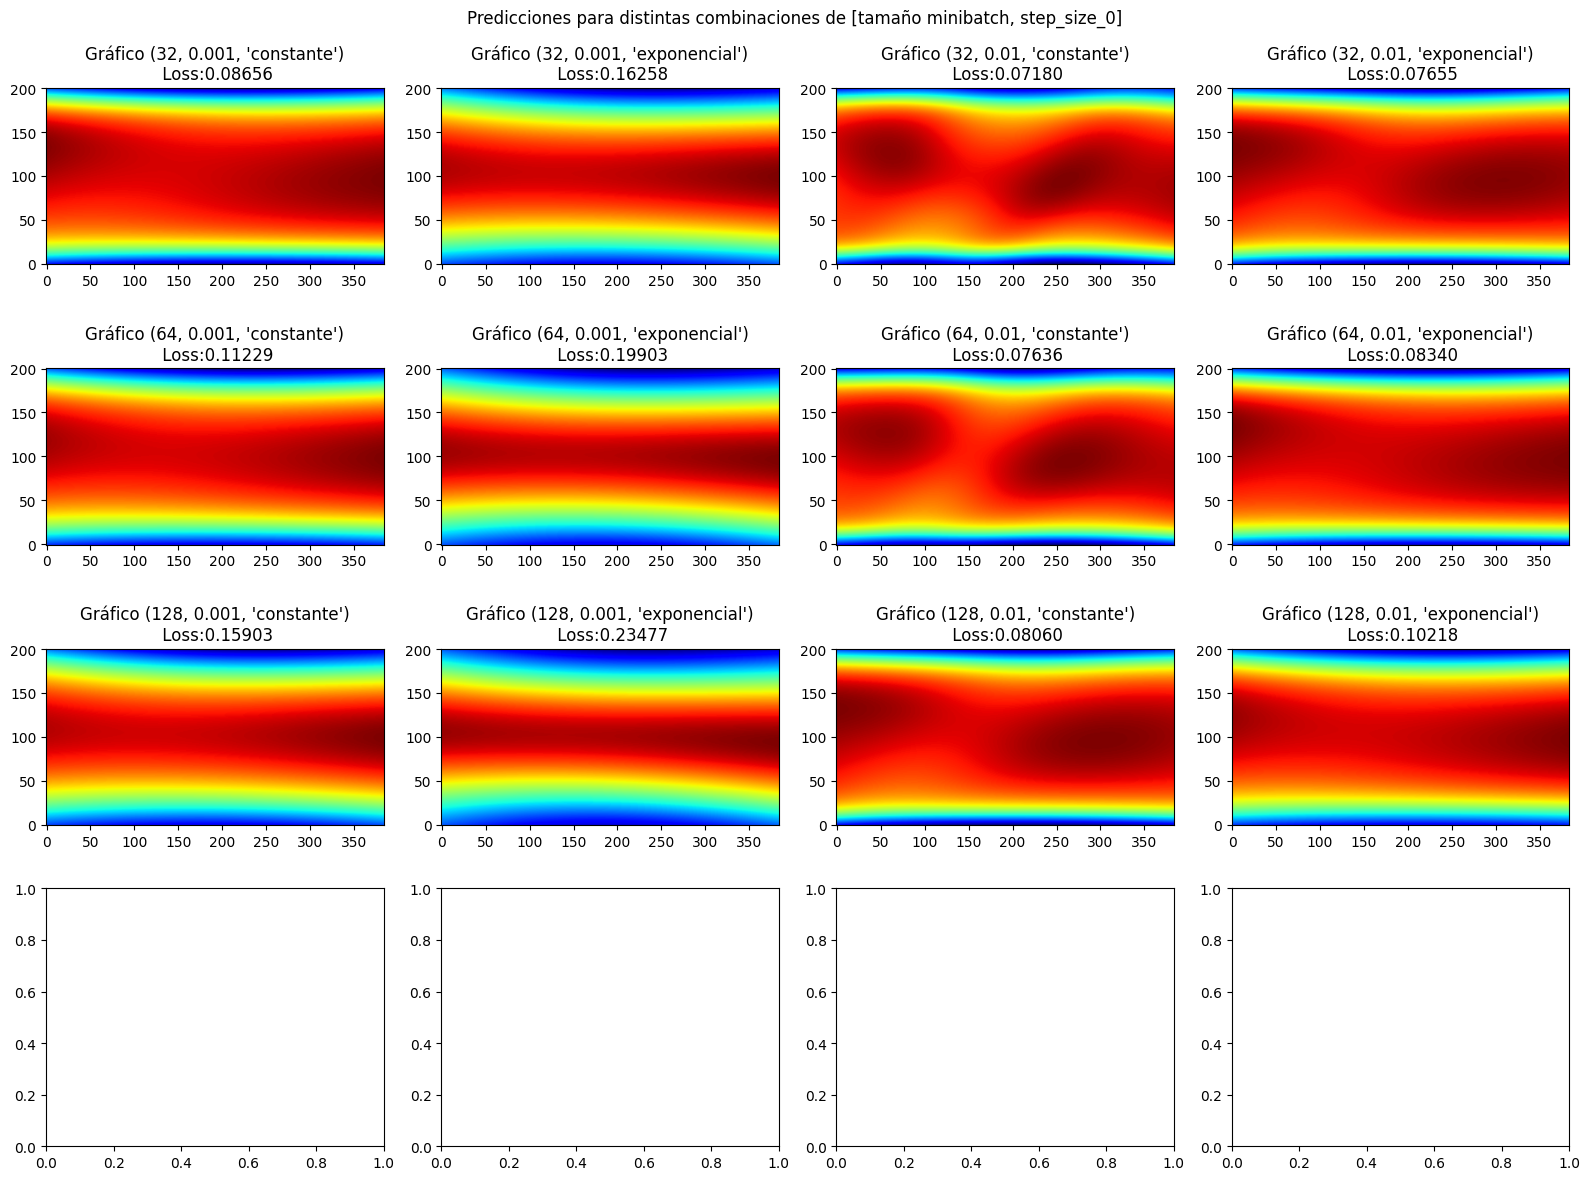

In [47]:
# Parámetros de la grilla
n, m = len(log_combinaciones)//4+1, 4              
total = n * m

fig, axes = plt.subplots(n, m, figsize=(4*m, 3*n))  # tamaño ajustable
fig.suptitle("Predicciones para distintas combinaciones de [tamaño minibatch, step_size_0]")

# Iterar por cada subplot
for i in range(len(log_combinaciones)):
    combinacion = log_combinaciones[i]
    
    row = i // m
    col = i % m
    ax = axes[row, col]
    
    result = batched_predict(combinacion[2], xx)
    
    ax.imshow(result.reshape((nx, ny)).T, origin='lower', cmap='jet')
    ax.set_title(f'Gráfico {combinacion[0]}\n Loss:{combinacion[1]:.5f}')

# Si sobran gráficos y algunos axes no los usaste, puedes ocultarlos:
for j in range(total, n*m):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()